<a href="https://colab.research.google.com/github/KD1994/EIP-Sessions/blob/master/Week-1/EIP_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torchsummary import summary

sns.set_style('darkgrid')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformation

In [0]:
my_transform = {
    'train': transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
}

# Dataset and Loader

In [0]:
BATCH_SZ = 64

trainset = datasets.MNIST(root='./data', train=True, 
                            download=True, transform=my_transform['train'])
train_loader = DataLoader(trainset, batch_size=BATCH_SZ, 
                         shuffle=True, num_workers=4)

testset = datasets.MNIST(root='./data', train=False, 
                           download=True, transform=my_transform['test'])
test_loader = DataLoader(testset, batch_size=BATCH_SZ, 
                        shuffle=False, num_workers=4)

# Data Exploration

<Figure size 432x288 with 0 Axes>

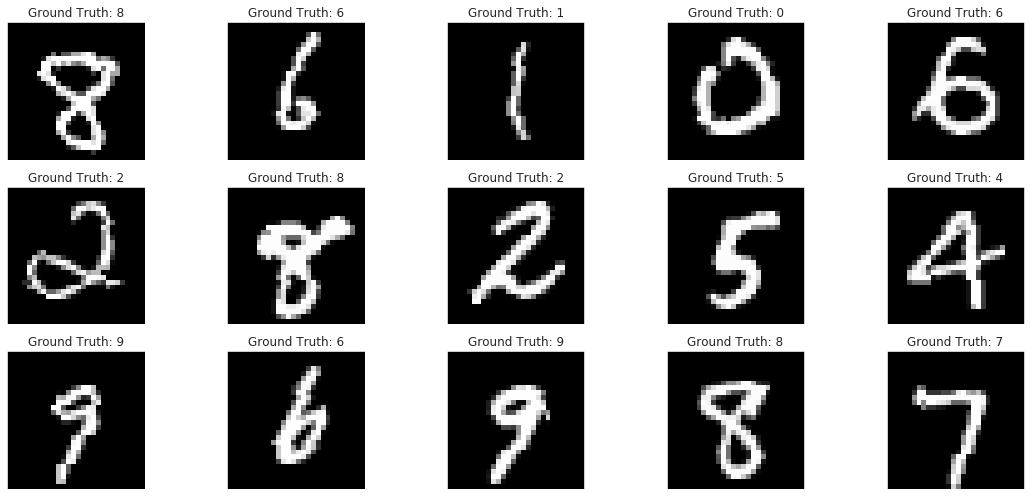

In [0]:
train_examples = enumerate(train_loader)
b_id, (train_ex_data, train_ex_truth) = next(train_examples)

plt.gray()
fig = plt.figure(figsize=(16, 7))

for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    ax.imshow(train_ex_data[i][0])
    ax.set_title("Ground Truth: {}".format(train_ex_truth[i].item()))
    ax.grid(False)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

# Batch Visualization

<Figure size 432x288 with 0 Axes>

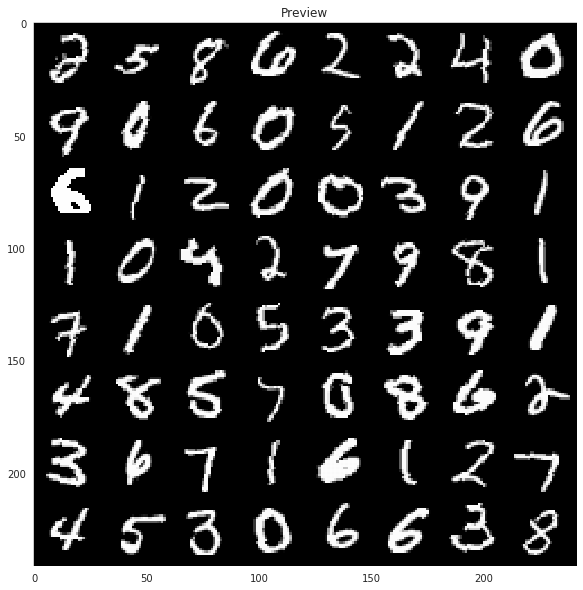

In [0]:
def imshow(img, title=''):
    
    plt.gray()
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.grid(False)
    plt.show()

for i, data in enumerate(train_loader):
    x, y = data
    imshow(make_grid(x, 8, normalize=True), title="Preview")
    break

# Model

## Model-1 : Model with fully connected layer

In [0]:
class MNIST_1(nn.Module):
    def __init__(self):
        super().__init__()

        """
        Calculate Output Shape: (Height + 2*Padding - dilation*(Kernel_size - 1) - 1) / Stride + 1
        """
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            # 28 + 2*0 - 1*(3 - 1) - 1 / 1 + 1 = 26
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, 2, padding=1),
            # 26 + 2*0 - 1*(3 - 1) - 1 / 2 + 1 = 13
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3),
            # 13 + 2*0 - 1*(3 - 1) - 1 / 1 + 1 = 11
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # 11 + 2*0 - 1*(2 - 1) - 1 / 2 + 1 = 5
            nn.Dropout2d(0.4),
            nn.Flatten()
        )

        self.fc = nn.Sequential(
            nn.Linear(64*5*5, 1028),
            nn.Linear(1028, 512),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.fc(x)
        return nn.functional.log_softmax(x, dim=1)

## Model-2 : Model with no fully conneced layer

In [0]:
class MNIST_2(nn.Module):
    def __init__(self):
        super().__init__()

        """
        Calculate Output Shape: (Height + 2*Padding - dilation*(Kernel_size - 1) - 1) / Stride + 1
        """
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3),
            # 28 + 2*0 - 1*(3 - 1) - 1 / 1 + 1 = 26
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3),
            # 26 + 2*0 - 1*(3 - 1) - 1 / 1 + 1 = 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, 2, padding=1),
            # 26 + 2*0 - 1*(3 - 1) - 1 / 2 + 1 = 12
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3),
            # 12 + 2*0 - 1*(3 - 1) - 1 / 1 + 1 = 10
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # 10 + 2*0 - 1*(2 - 1) - 1 / 2 + 1 = 5
            nn.Conv2d(64, 10, 1),
            # 5 + 2*0 - 1*(1 - 1) - 1 / 1 + 1 = 5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 10, 5),
            # 5 + 2*0 - 1*(3 - 1) - 1 / 1 + 1 = 1
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.4),
            nn.Flatten()
        )
    
    def forward(self, x):
        x = self.conv1(x)
        return nn.functional.log_softmax(x, dim=1)

In [0]:
model_1 = MNIST_1()
model_1 = model_1.to(device)
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

model_2 = MNIST_2()
model_2 = model_2.to(device)
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)
criterion = nn.NLLLoss()

In [0]:
summary(model_1, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 32, 13, 13]           4,640
              ReLU-5           [-1, 32, 13, 13]               0
       BatchNorm2d-6           [-1, 32, 13, 13]              64
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
       BatchNorm2d-9           [-1, 64, 11, 11]             128
        MaxPool2d-10             [-1, 64, 5, 5]               0
        Dropout2d-11             [-1, 64, 5, 5]               0
          Flatten-12                 [-1, 1600]               0
           Linear-13                 [-1, 1028]       1,645,828
           Linear-14                  [

In [0]:
summary(model_2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,320
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 32, 12, 12]           4,640
              ReLU-8           [-1, 32, 12, 12]               0
       BatchNorm2d-9           [-1, 32, 12, 12]              64
           Conv2d-10           [-1, 64, 10, 10]          18,496
             ReLU-11           [-1, 64, 10, 10]               0
      BatchNorm2d-12           [-1, 64, 10, 10]             128
        MaxPool2d-13             [-1, 64, 5, 5]               0
           Conv2d-14             [-1, 1

# Training & Validation

## Model-1

In [0]:
%%time
import time
import copy

epochs = 10
train_losses, test_losses = [], []
train_accu, test_accu = [], []

for e in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0

    # training step
    model_1.train()
    for images, labels in train_loader:
        # Load data to GPU
        images = images.to(device)
        labels = labels.to(device)

        optimizer_1.zero_grad()
        output = model_1(images)
        
        # Compute the accuracy
        ret, predictions = torch.max(output.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        accuracy += torch.mean(correct_counts.type(torch.FloatTensor))
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer_1.step()
        
        running_loss += loss.item()
        del images, labels, output
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(accuracy/len(train_loader))

    # Testing step
    test_loss = 0
    accuracy=0
    model_1.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model_1(images)
            
            # Compute the accuracy
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            accuracy += torch.mean(correct_counts.type(torch.FloatTensor))
        
            test_loss += criterion(output, labels)
            
            del images, labels, output

    test_losses.append(test_loss/len(test_loader))
    test_accu.append(accuracy/len(test_loader))

    print("Epoch: {}/{}  ".format(e+1, epochs),
          "Time: {:.2f}s  ".format(time.time()-epoch_start_time),
          "Training Loss: {:.3f}  ".format(train_losses[-1]),
          "Training Accu: {:.3f}  ".format(train_accu[-1]),
          "Test Loss: {:.3f}  ".format(test_losses[-1]),
          "Test Accu: {:.3f}".format(test_accu[-1]))

    
best_model_1_wts = copy.deepcopy(model_1.state_dict())
model_1.load_state_dict(best_model_1_wts)

Epoch: 1/10   Time: 11.59s   Training Loss: 0.280   Training Accu: 0.920   Test Loss: 0.073   Test Accu: 0.978
Epoch: 2/10   Time: 11.56s   Training Loss: 0.102   Training Accu: 0.969   Test Loss: 0.049   Test Accu: 0.984
Epoch: 3/10   Time: 11.31s   Training Loss: 0.078   Training Accu: 0.976   Test Loss: 0.039   Test Accu: 0.988
Epoch: 4/10   Time: 11.39s   Training Loss: 0.068   Training Accu: 0.979   Test Loss: 0.039   Test Accu: 0.987
Epoch: 5/10   Time: 11.41s   Training Loss: 0.061   Training Accu: 0.981   Test Loss: 0.033   Test Accu: 0.988
Epoch: 6/10   Time: 11.47s   Training Loss: 0.057   Training Accu: 0.982   Test Loss: 0.034   Test Accu: 0.988
Epoch: 7/10   Time: 11.40s   Training Loss: 0.052   Training Accu: 0.984   Test Loss: 0.030   Test Accu: 0.989
Epoch: 8/10   Time: 11.54s   Training Loss: 0.050   Training Accu: 0.984   Test Loss: 0.028   Test Accu: 0.991
Epoch: 9/10   Time: 11.44s   Training Loss: 0.046   Training Accu: 0.985   Test Loss: 0.027   Test Accu: 0.991
E

## Plot Accuracy and Loss Graph

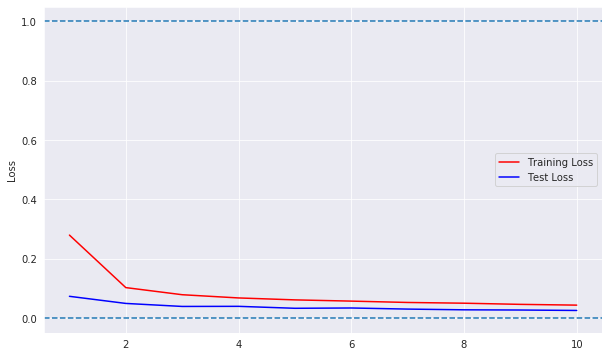

In [0]:
# Training Loss & Test Loss
plt.figure(figsize=(10,6))

plt.ylabel('Loss')
plt.plot(range(1, epochs + 1), train_losses[:epochs+1], 'r', label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses[:epochs+1], 'b', label='Test Loss')
plt.axhline(y=0, linestyle='--')
plt.axhline(y=1, linestyle='--')
plt.legend()

plt.show()

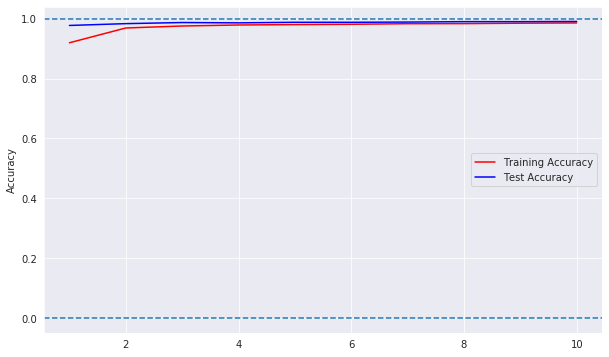

In [0]:
# Training Accuracy & Test Accuracy
plt.figure(figsize=(10,6))

plt.ylabel('Accuracy')
plt.plot(range(1, epochs + 1), train_accu[:epochs+1], 'r', label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accu[:epochs+1], 'b', label='Test Accuracy')
plt.axhline(y=0, linestyle='--')
plt.axhline(y=1, linestyle='--')
plt.legend()

plt.show()

## Model-2

In [0]:
%%time
import time
import copy

epochs = 10
train_losses, test_losses = [], []
train_accu, test_accu = [], []

for e in range(epochs):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0
    # training step
    model_2.train()
    for images, labels in train_loader:
        # Load data to GPU
        images = images.to(device)
        labels = labels.to(device)

        optimizer_2.zero_grad()
        output = model_2(images)
        
        # Compute the accuracy
        ret, predictions = torch.max(output.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
         
        # Convert correct_counts to float and then compute the mean
        accuracy += torch.mean(correct_counts.type(torch.FloatTensor))
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer_2.step()
        
        running_loss += loss.item()
        del images, labels, output
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(accuracy/len(train_loader))

    # Testing Part
    test_loss = 0
    accuracy=0
    model_2.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model_2(images)
            
            # Compute the accuracy
            ret, predictions = torch.max(output.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            accuracy += torch.mean(correct_counts.type(torch.FloatTensor))
        
            test_loss += criterion(output, labels)
            
            del images, labels, output

    test_losses.append(test_loss/len(test_loader))
    test_accu.append(accuracy/len(test_loader))

    print("Epoch: {}/{}  ".format(e+1, epochs),
          "Time: {:.2f}s  ".format(time.time()-epoch_start_time),
          "Training Loss: {:.3f}  ".format(train_losses[-1]),
          "Training Accu: {:.3f}  ".format(train_accu[-1]),
          "Test Loss: {:.3f}  ".format(test_losses[-1]),
          "Test Accu: {:.3f}".format(test_accu[-1]))

    
best_model_2_wts = copy.deepcopy(model_2.state_dict())
model_2.load_state_dict(best_model_2_wts)

Epoch: 1/10   Time: 12.52s   Training Loss: 1.037   Training Accu: 0.626   Test Loss: 0.288   Test Accu: 0.978
Epoch: 2/10   Time: 12.39s   Training Loss: 0.856   Training Accu: 0.672   Test Loss: 0.196   Test Accu: 0.983
Epoch: 3/10   Time: 12.30s   Training Loss: 0.806   Training Accu: 0.677   Test Loss: 0.156   Test Accu: 0.986
Epoch: 4/10   Time: 12.49s   Training Loss: 0.774   Training Accu: 0.681   Test Loss: 0.127   Test Accu: 0.987
Epoch: 5/10   Time: 12.51s   Training Loss: 0.762   Training Accu: 0.678   Test Loss: 0.119   Test Accu: 0.987
Epoch: 6/10   Time: 12.30s   Training Loss: 0.741   Training Accu: 0.681   Test Loss: 0.095   Test Accu: 0.990
Epoch: 7/10   Time: 12.39s   Training Loss: 0.721   Training Accu: 0.685   Test Loss: 0.091   Test Accu: 0.989
Epoch: 8/10   Time: 12.28s   Training Loss: 0.718   Training Accu: 0.681   Test Loss: 0.077   Test Accu: 0.990
Epoch: 9/10   Time: 12.38s   Training Loss: 0.710   Training Accu: 0.685   Test Loss: 0.076   Test Accu: 0.989
E

## Plot Accuracy and Loss Graph

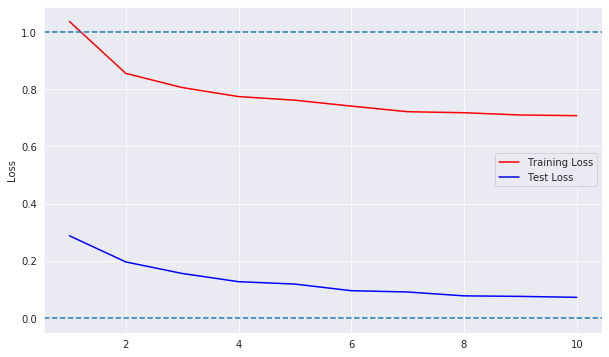

In [0]:
# Training Loss & Test Loss
plt.figure(figsize=(10,6))

plt.ylabel('Loss')
plt.plot(range(1, epochs + 1), train_losses[:epochs+1], 'r', label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses[:epochs+1], 'b', label='Test Loss')
plt.axhline(y=0, linestyle='--')
plt.axhline(y=1, linestyle='--')
plt.legend()

plt.show()

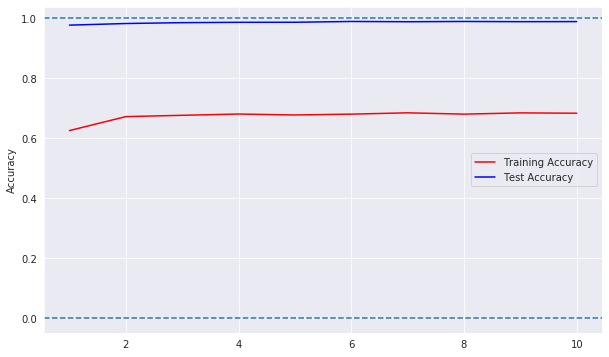

In [0]:
# Training Accuracy & Test Accuracy
plt.figure(figsize=(10,6))

plt.ylabel('Accuracy')
plt.plot(range(1, epochs + 1), train_accu[:epochs+1], 'r', label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accu[:epochs+1], 'b', label='Test Accuracy')
plt.axhline(y=0, linestyle='--')
plt.axhline(y=1, linestyle='--')
plt.legend()

plt.show()

# Predicted Example

<Figure size 432x288 with 0 Axes>

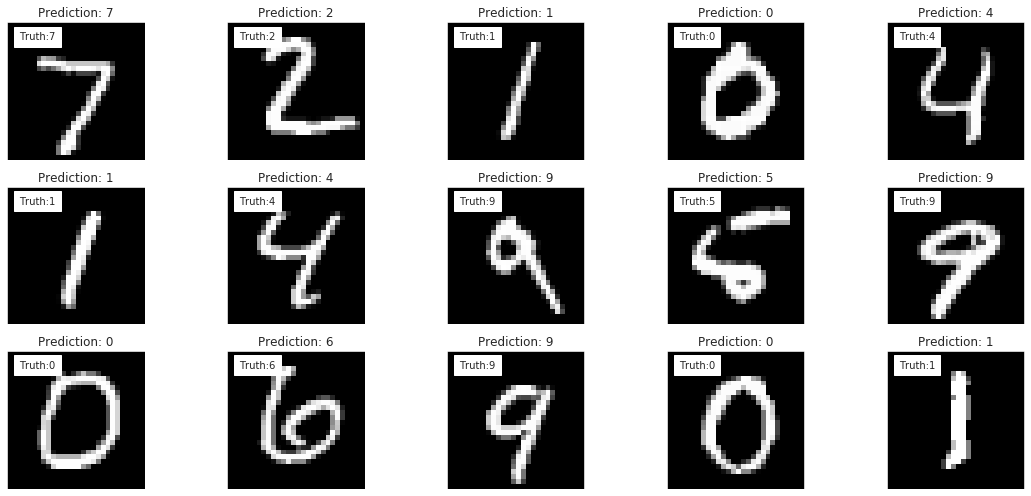

In [0]:
# Prediction with Model-1

test_examples = enumerate(test_loader)
b_id, (test_ex_data, test_ex_truth) = next(test_examples)


with torch.no_grad():
    output = model_1(test_ex_data.cuda())

plt.gray()
fig = plt.figure(figsize=(16, 7))

for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    ax.imshow(test_ex_data[i][0])
    label = 'Truth:' + str(test_ex_truth[i].item())
    ax.set_title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    ax.text(2, 3, label, bbox={'facecolor': 'white', 'pad': 5})
    ax.grid(False)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()